<a href="https://colab.research.google.com/github/TrinhHoangKhang/Math-for-AI/blob/main/5.%20Image%20retrieval/Traditional_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image retrieval
Có một ảnh query, nhiệm vụ của ta là tìm các ảnh có đặc điểm giống với ảnh query trong một tập các ảnh <br>
Chúng ta sẽ dùng 3 loại distance metric:
- L1 norm
- L2 norm
- Cosine similarity
Với mỗi ảnh ta coi như dàn tất cả các giá trị ra thành một vector, tương tự với ảnh query, sau đó ta dùng các distance metric trên với 2 vector đó


---

#### Dowload dataset

dataset có cấu trúc như sau:
- Data
  - train
    - class1
    - class2
  - test
    - class1
    - class2
Mỗi folder train, test gồm nhiều folder, mỗi folder là một class ảnh.
Tập test là những ảnh mà ta sẽ chọn để query, tập train chính là tập các ảnh mà chúng ta sẽ query trên.

In [1]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=f8a2a322-d375-4161-9f0b-a63243af7123
To: /content/data.zip
100% 76.1M/76.1M [00:00<00:00, 200MB/s]


In [2]:
!unzip data

Archive:  data.zip
   creating: data/
   creating: data/.ipynb_checkpoints/
   creating: data/test/
   creating: data/test/American_egret/
  inflating: data/test/American_egret/n02009912_2473.JPEG  
   creating: data/test/Doberman/
  inflating: data/test/Doberman/n02107142_52285.JPEG  
   creating: data/test/Rhodesian_ridgeback/
  inflating: data/test/Rhodesian_ridgeback/n02087394_18723.JPEG  
   creating: data/test/African_crocodile/
  inflating: data/test/African_crocodile/n01697457_18534.JPEG  
   creating: data/test/Lakeland_terrier/
  inflating: data/test/Lakeland_terrier/n02095570_4644.JPEG  
   creating: data/test/ambulance/
  inflating: data/test/ambulance/n02701002_2311.JPEG  
   creating: data/test/apiary/
  inflating: data/test/apiary/n02727426_4398.JPEG  
   creating: data/test/bannister/
  inflating: data/test/bannister/n02788148_47071.JPEG  
   creating: data/test/basketball/
  inflating: data/test/basketball/n02802426_12693.JPEG  
   creating: data/test/barn_spider/
  in

---

#### Import thư viện cần thiết

In [3]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os

---

### Các hàm dùng để lấy dữ liệu
Trước tiên cần biết để dùng hàm so distance metric thì ta cần 2 thứ: ảnh query và tất cả ảnh trong folder bộ ảnh mà ta query lên.
Đồng thời khi đọc ảnh cần phải cùng một kích thước nên ta viết lại hàm đọc ảnh

In [4]:
ROOT = 'data'
IMG_SIZE = (448, 448)

In [5]:
def read_img(path, size):
  '''
  Read image from path and resize to size
  '''
  img = cv.imread(path)
  img = cv.resize(img, size)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img = img.astype(np.float32)
  return img


def get_all_img(pool_path, size):
  '''
  Given pool path, return a list of all image and its path
  '''
  img_list = []
  img_path_list = []
  for img_class in os.listdir(pool_path):
    class_path = os.path.join(pool_path, img_class)
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = read_img(img_path, size)
      img_path_list.append(img_path)
      img_list.append(img)

  return np.array(img_list), np.array(img_path_list)

---

### Các hàm distance metric

#### L1 norm

In [6]:
def l1_norm(query_img, target_img_ls):
  '''
  Calculate L1 norm distance between query image and target image list
  Return a list of distances
  '''
  axis_batch_size = (1, 2, 3)
  return np.sum(np.abs(target_img_ls - query_img), axis=axis_batch_size)

#### L2 Norm

In [7]:
def l2_norm(query_img, target_img_ls):
  '''
  Calculate L2 norm distance between query image and target image list
  Return a list of distances
  '''
  axis_batch_size = (1, 2, 3)
  return np.sqrt(np.sum((target_img_ls - query_img)**2, axis=axis_batch_size))

#### Cosine similarity

In [8]:
def cosine_similarity(query_img, target_img_ls):
  '''
  Calculate Cosine similarity between query image and target image list
  Return a list of distances
  '''
  axis_batch_size = (1, 2, 3)
  dot_product = np.sum(query_img * target_img_ls, axis=axis_batch_size)
  query_norm = np.sqrt(np.sum(query_img**2))
  target_norm = np.sqrt(np.sum(target_img_ls**2, axis=axis_batch_size))
  return dot_product / (query_norm * target_norm)

---


### Hàm vẽ đồ thị kết quả


In [9]:
def plot_results(query_img_path, result_img_paths, size):
    fig = plt.figure(figsize=(15, 9))
    fig.add_subplot(2, 3, 1)
    plt.imshow(read_img(query_img_path, size).astype(np.uint8))
    plt.title(f"Query Image: {query_img_path.split('/')[2]}", fontsize=16)
    plt.axis("off")
    for i, path in enumerate(result_img_paths, 2):
        fig.add_subplot(2, 3, i)
        plt.imshow(read_img(path, size).astype(np.uint8))
        plt.title(f"Top {i-1}: {path.split('/')[2]}", fontsize=16)
        plt.axis("off")
    plt.show()

---

### Tiến hành query

In [10]:
def query(query_img, pool_path, distance_metric, size):
  target_img_ls, target_img_paths = get_all_img(pool_path, size)
  distances = distance_metric(query_img, target_img_ls)
  path_and_distance = list(zip(target_img_paths, distances))
  path_and_distance.sort(key=lambda x: x[1])
  return path_and_distance

#### L1 Norm

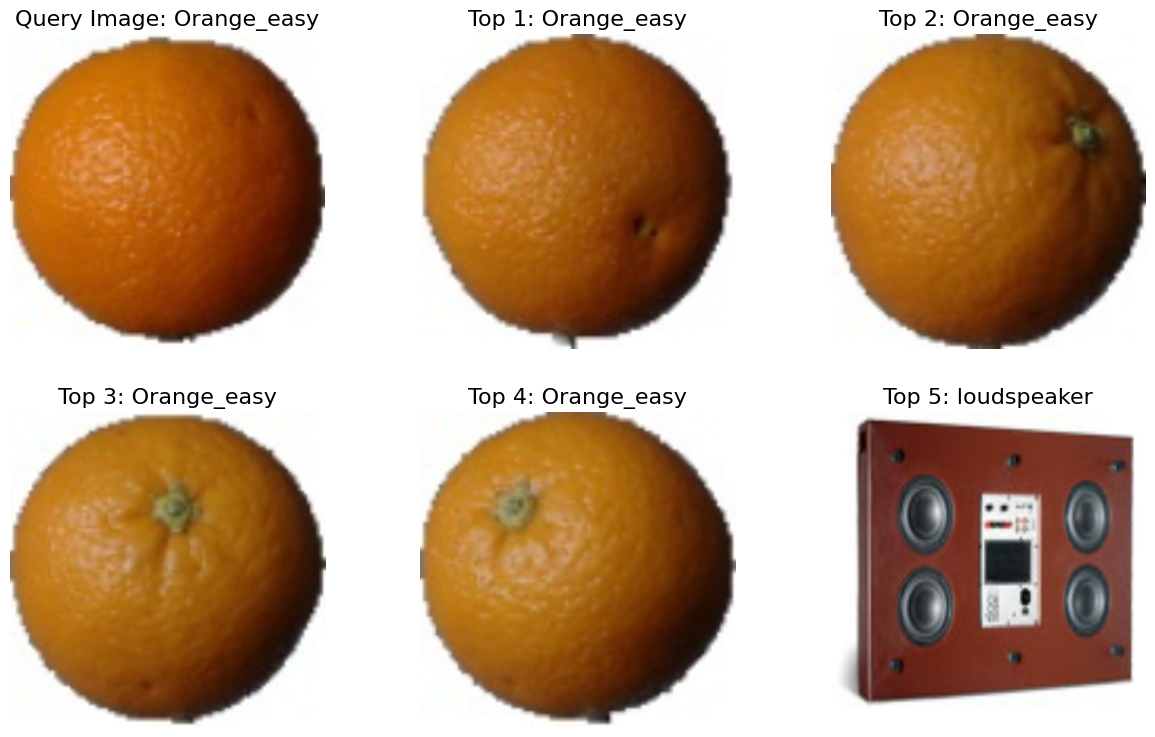

In [11]:
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
pool_path = f"{ROOT}/train"

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l1_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[:5]
top5_distances = distances[:5]
plot_results(query_path, top5_img_paths, IMG_SIZE)

#### L2 norm

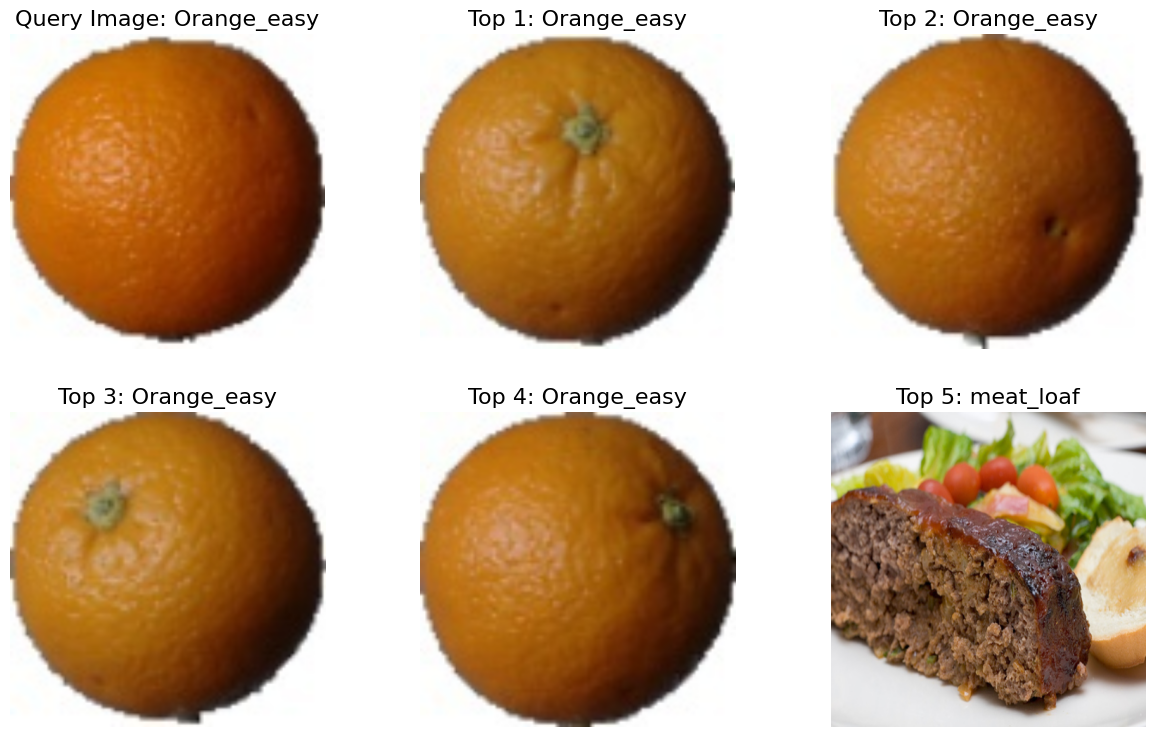

In [12]:
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
pool_path = f"{ROOT}/train"

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l2_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[:5]
top5_distances = distances[:5]
plot_results(query_path, top5_img_paths, IMG_SIZE)

#### Cosine similarity

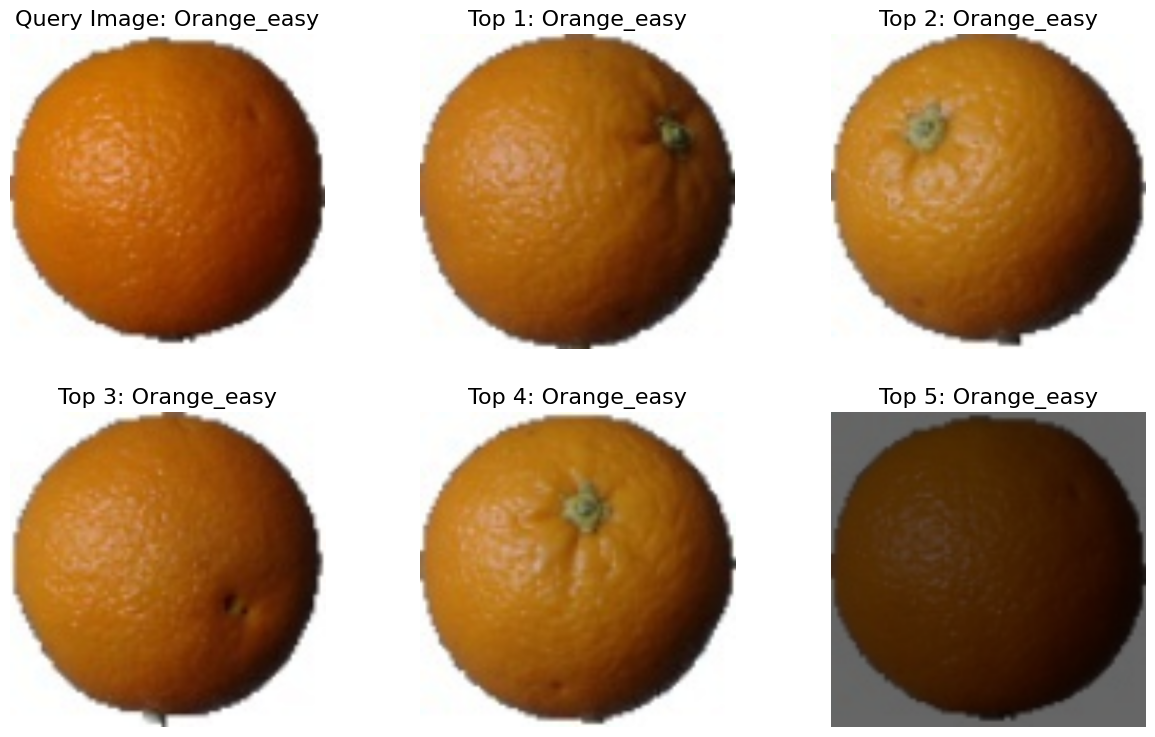

In [13]:
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
pool_path = f"{ROOT}/train"

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, cosine_similarity, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[-5:]
top5_distances = distances[-5:]
plot_results(query_path, top5_img_paths, IMG_SIZE)

---

### Test trên một số hình khác

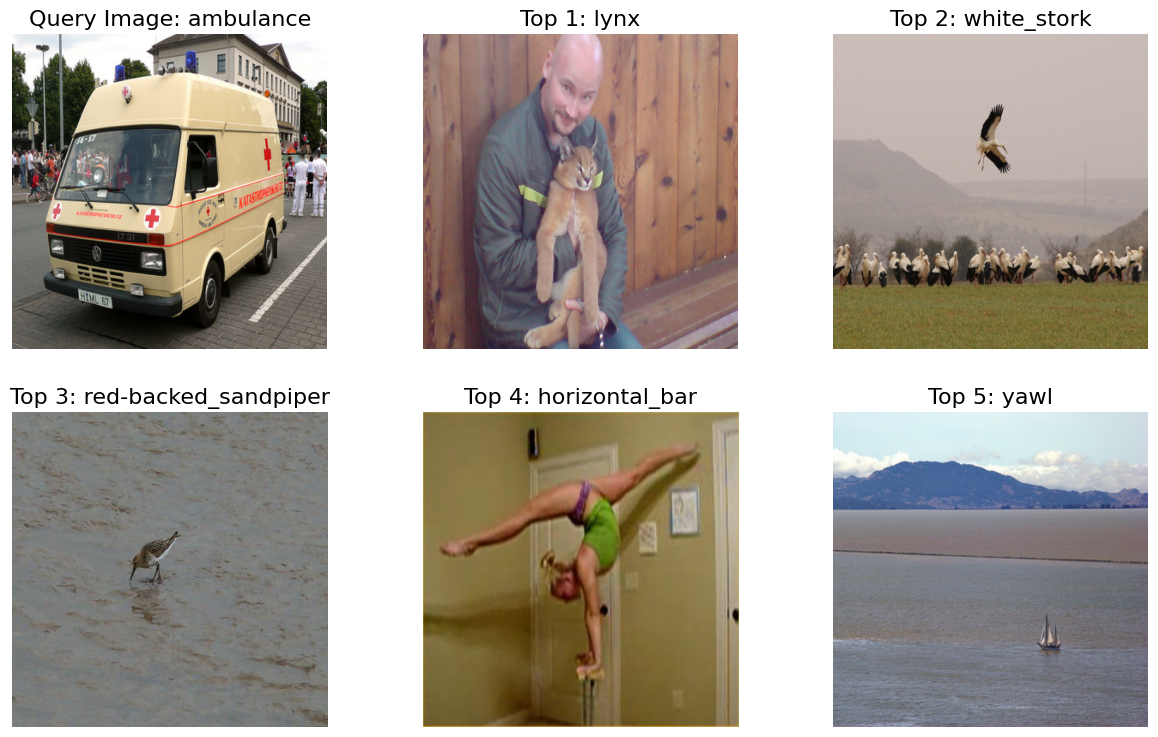

In [18]:
query_path = f'{ROOT}/test/ambulance/n02701002_2311.JPEG'
pool_path = f'{ROOT}/train'

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l1_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[:5]
top5_distances = distances[:5]
plot_results(query_path, top5_img_paths, IMG_SIZE)

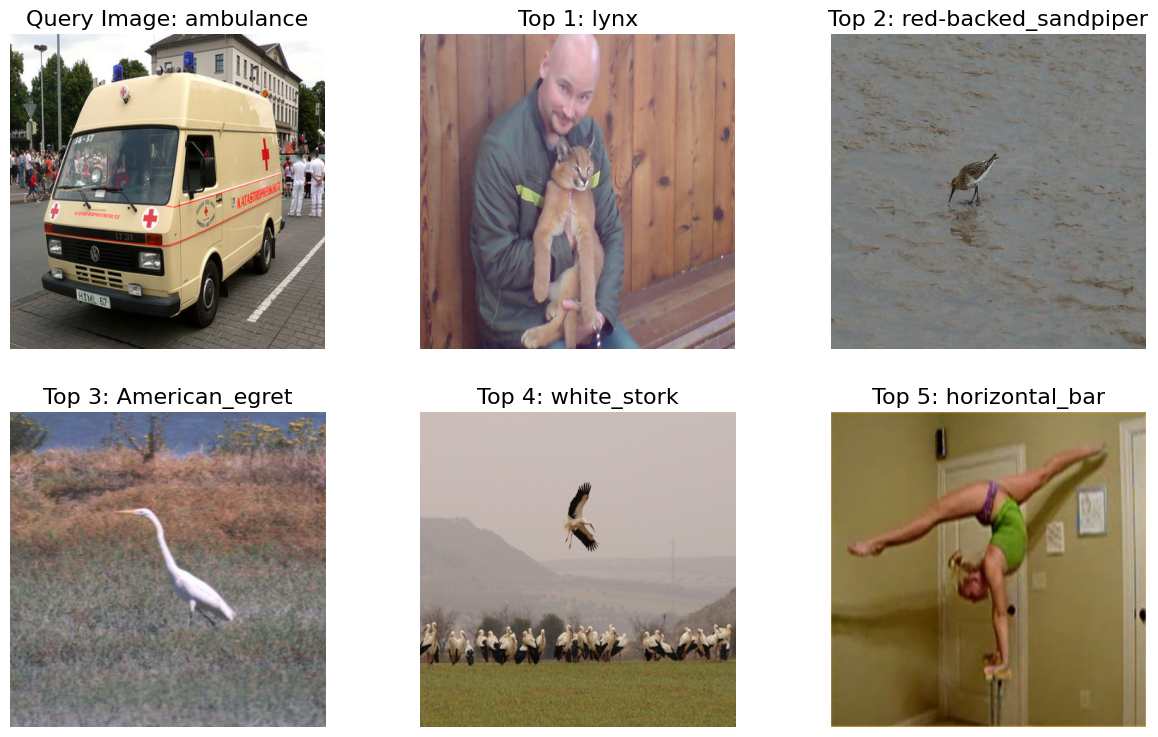

In [19]:
query_path = f'{ROOT}/test/ambulance/n02701002_2311.JPEG'
pool_path = f'{ROOT}/train'

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l2_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[:5]
top5_distances = distances[:5]
plot_results(query_path, top5_img_paths, IMG_SIZE)

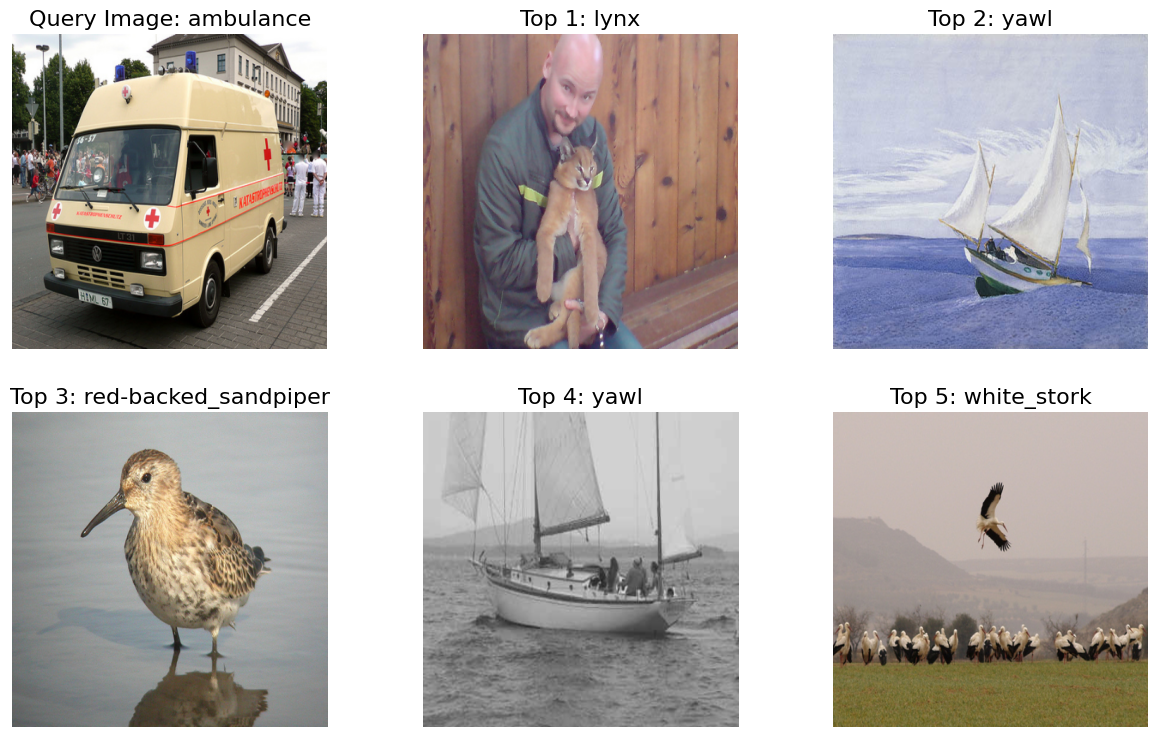

In [20]:
query_path = f'{ROOT}/test/ambulance/n02701002_2311.JPEG'
pool_path = f'{ROOT}/train'

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, cosine_similarity, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[-5:]
top5_distances = distances[-5:]
plot_results(query_path, top5_img_paths, IMG_SIZE)

---

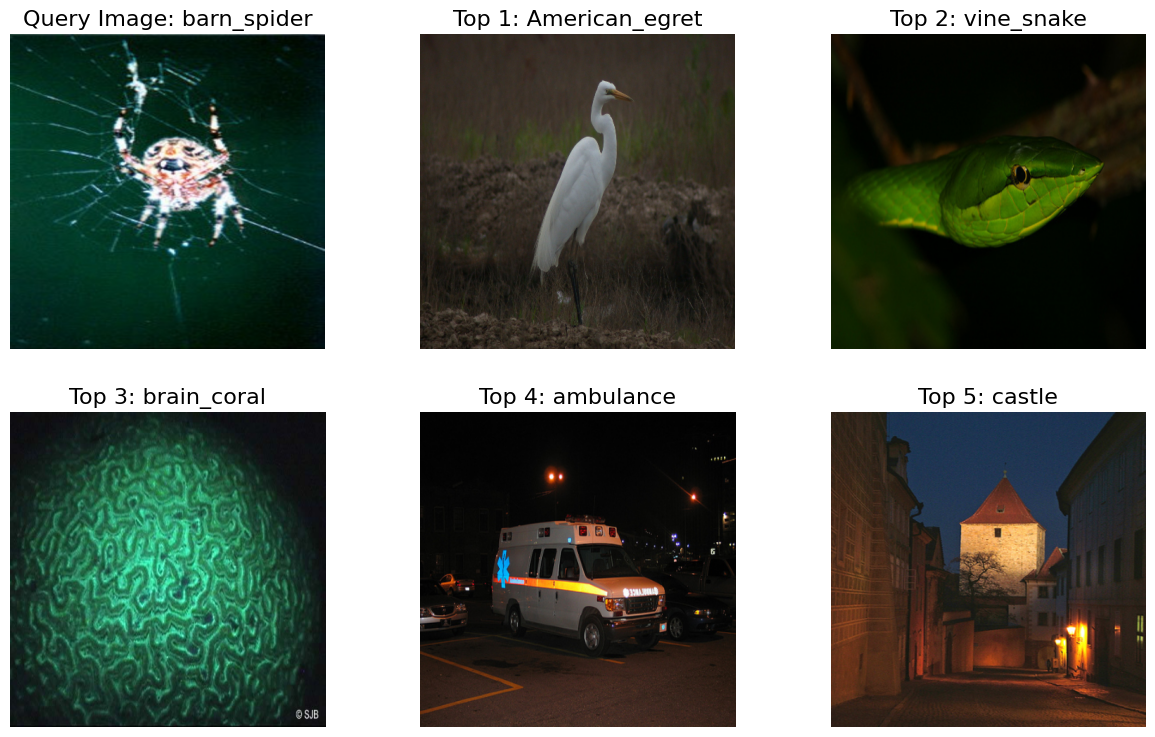

In [22]:
query_path = f'{ROOT}/test/barn_spider/n01773549_3207.JPEG'
pool_path = f'{ROOT}/train'

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l1_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)

top5_img_paths = img_paths[:5]
top5_distances = distances[:5]
plot_results(query_path, top5_img_paths, IMG_SIZE)